<center><h1>Desafio Data Science - Creditas </h1></center>
<h3> Bruno Borges de Souza </h3>

O objetivo deste desafio é construir um modelo de classificação que retorne a probabilidade que um cliente tem de ser enviado para análise de crédito dado que ele foi pré-aprovado para o empréstimo com garantia de automóvel. Deste modo, a Creditas pode priorizar clientes com maior probabilidade a serem atendidos primeiro.

# Conteúdo

* [<font size=4>Análise Exploratória de dados</font>](#1)
    * [Carregando a base](#1.1)
    * [Tratando dados faltantes e fazendo a seleção de varáveis](#1.2)
    * [Remoção de outliers](#1.3)
    * [Normalização](#1.4)
    * [Transformação das variáveis categóricas](#1.5)
    * [Mapa de correlação entre variáveis](#1.6)
    * [Visualização da base final ](#1.7)

    
* [<font size=4>Modelagem - Etapa 1</font>](#2)
    * [Verificar se a base está balanceada ](#2.1)
    * [Aplicando o modelo de machine learning - XGBoost ](#2.2)
    * [Calibração de probabilidades](#2.3)
    * [Métrica de avaliação - Área sob a curva ROC](#2.4)
    * [Outras métricas importantes](#2.5)
    * [Importância via permutação das variáeis](#2.6)

* [<font size=4>Modelagem - Etapa 2</font>](#3)
    * [Aplicando o modelo de machine learning - Random Forest](#3.1)
    * [Avaliação do modelo](#3.2)
    * [Feature Importance](#3.3)
    * [Importância via permutação das variáeis](#3.4)

* [<font size=4>Conclusão</font>](#4)


### Importação das bibliotecas necessárias

In [3]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import random
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.calibration import CalibratedClassifierCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import missingno as msno 
import eli5
import scikitplot as skplt
from imblearn.over_sampling import SMOTE
from eli5.sklearn import PermutationImportance
warnings.filterwarnings("ignore") 


# Análise Exploratória de dados <a id="1"></a>

### Carregando a base <a id="1.1"></a>

Primeiramente, vamos carregar a base e obter uma descrição básica sobre o tipo de dados nas colunas e verificar se há dados nulos.

In [4]:
base = pd.read_csv('dataset.csv')
description = pd.read_csv('description.csv')
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35021 entries, 0 to 35020
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    35021 non-null  int64  
 1   age                   35019 non-null  float64
 2   monthly_income        35019 non-null  float64
 3   collateral_value      35000 non-null  float64
 4   loan_amount           35018 non-null  float64
 5   city                  34998 non-null  object 
 6   state                 35017 non-null  object 
 7   collateral_debt       24650 non-null  float64
 8   verified_restriction  26329 non-null  float64
 9   dishonored_checks     35021 non-null  int64  
 10  expired_debts         35021 non-null  int64  
 11  banking_debts         35021 non-null  int64  
 12  commercial_debts      35021 non-null  int64  
 13  protests              35021 non-null  int64  
 14  marital_status        415 non-null    object 
 15  informed_restrictio

### Tratando dados faltantes e fazendo a seleção de varáveis  <a id="1.2"></a>

O gráfico de barras abaixo, conta o número de dados não-nulos na base. Podemos verificar que algumas colunas possuem muitos dados faltantes, e um tratamento particular para lidar com essas informações faltantes torna-se necessário.

<AxesSubplot:>

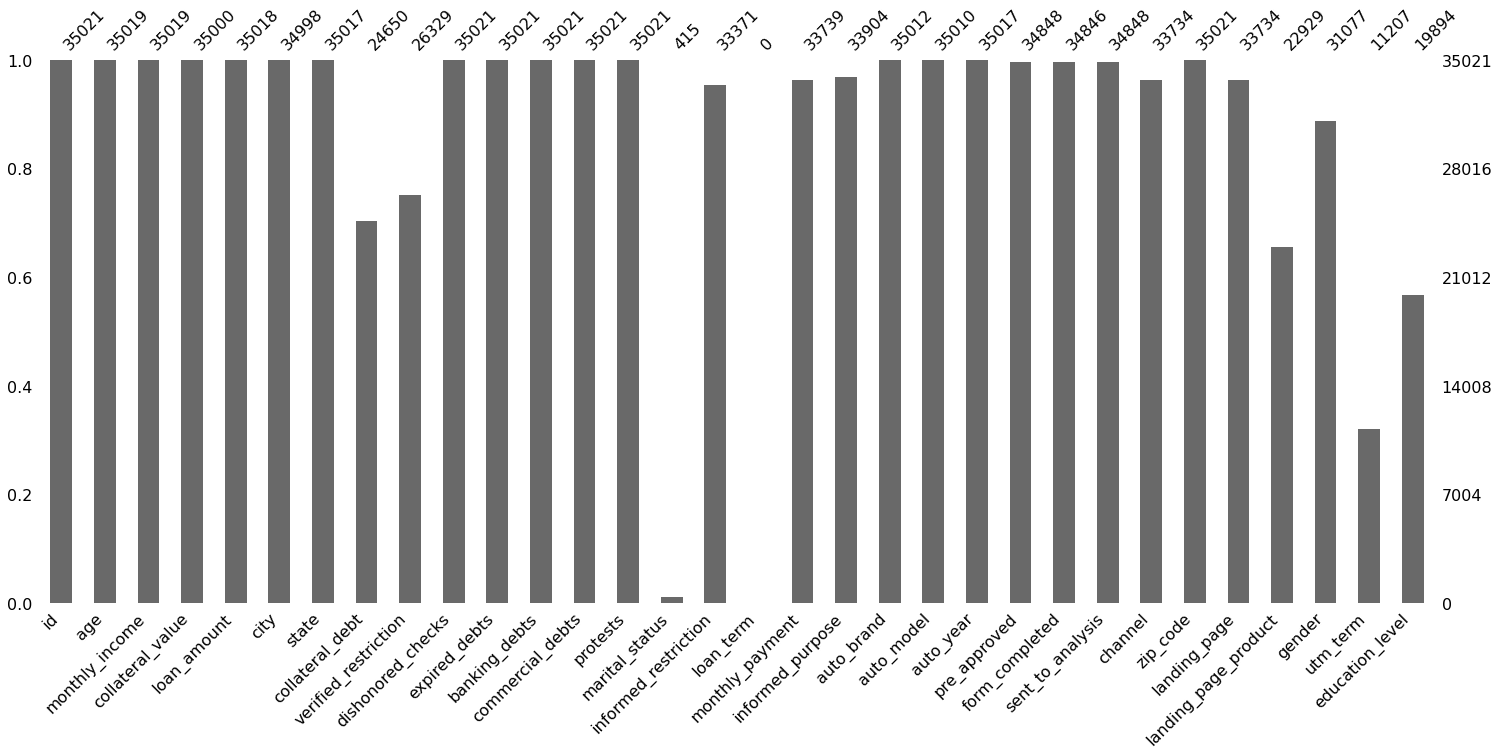

In [5]:
msno.bar(base) 

Para as colunas com poucos dados faltantes, iremos apenas deletar as instâncias com NaN.

In [6]:
base.index = base['id']
#remover nan nas colunas
base_pre1 = base.dropna(subset=['age', 'monthly_income', 'collateral_value', 'loan_amount', 'monthly_payment', 'auto_brand', 'pre_approved', 'form_completed', 'sent_to_analysis', 'collateral_value'])


As colunas marital_status e loan_term possuem uma porcentagem de dados faltantes que torna tais colunas inúteis para predição. As colunas id, city, auto_model, auto_brand e utm_term não servem para previsão, já que são variáveis categóricas id ou com muitas categorias).

In [7]:
#deletar colunas irrelevantes (id, city, state, informed_purpose, auto_model, gender) e comquantidades excessivas de nan (utm_term, marital_status, loan_term, landing_page_product)
base_pre2 = base_pre1.drop(['id', 'city', 'informed_purpose', 'auto_model', 'auto_brand','utm_term', 'marital_status', 'loan_term'], axis=1)


Como a variável collateral_debt possui uma quantidade consderável de dados faltantes (35%) e é uma variável numérica, optamos aqui por substituir os dados faltantes pela mediana da coluna (a mediana é mais robusta a outliers que a média). Os dados faltantes de outras variáveis serão incorporadas como uma nova categoria na coluna. O motivo é que tais dados podem ter um significado que afeta a previsão. Na variável verified_restriction, dados Nan significa que a informação não foi preenchida pelo usuário, e o mesmo talvez se aplique à variável education_level, gender e landing_page_prduct (análises posteriores verificando o desempenho de previsão excluindo os dados faltantes dessas variáveis levou a um desempenho pior de acordo com a métrica AuC-ROC). 

In [8]:
# substituir nan de collateral_debt pela mediana.
base_pre2['collateral_debt'] = base_pre2['collateral_debt'].fillna(np.median(base_pre2.collateral_debt))

A criação de duas variáveis pareceu razoável acrescentar à base: 
<ul>
  <li><b>Total_value</b>, que representa a porcentagem da quantidade emprestada (loan_amount) com relação ao valor da garantia (valor do carro + dívida do carro).</li>
  <li><b>Total_monthly</b>, que representa a porcentagem do valor da mensalidade com relação ao salário do cliente.</li>
</ul>

In [9]:
#criar coluna Total_value que representa a porcentagem da empréstimo com relação à garantia
base_pre2['Total_value'] = base_pre2.loan_amount/(base_pre2.collateral_debt+base_pre2.collateral_value)

#criar coluna Total_monthly que representa a porcentagem entre a mensalidade paga e a renda mensal
base_pre2['Total_monthly'] = base_pre2.monthly_payment/base_pre2.monthly_income

É necessário um tratamento com relação à variável zip_code, pois poderia gerar uma quantidade excessiva de categorias que apenas acrescentaria ruído para a previsão. Vamos selecionar apenas o primeiro dígito, que informa a região  do país onde o cliente mora, sendo útil para análise.

In [10]:
#selecionar região a partir do primeiro dígito do zip code
base_pre2.zip_code = base_pre2.zip_code.str[:1]

### Remoção de outliers  <a id="1.3"></a>

A base de dados contém uma quantidade considerável de outliers devido a erros de digitação. O método utilizado para remoção de outliers foi aplicar uma função que analisa o intervalo interquartil (IRQ) a fim de avaliar o grau de dispersão de dados em torno da medida de centralidade. Caso o IQR, multiplicado por uma constante, ultrapasse um determinado limiar, deverá ser considerado um outlier. A constante foi defnida de forma a detectar como outliers apenas valores que fossem irreais para a variável em questão.

In [11]:
#remover outliers por erros de digitação ou valores irreais
base_pre3 = base_pre2.copy()

In [12]:
#remover outliers por erros de digitação ou valores irreais
base_pre3 = base_pre2.copy()
def remover_outliers(x, const):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    return x < (Q1 + const*IQR)

base_pre3 = base_pre3[remover_outliers(base_pre3.age, 3.5)] #limiar de 86 anos
base_pre3 = base_pre3[remover_outliers(base_pre3.Total_value, 5)] # limiar de 2.57
base_pre3 = base_pre3[remover_outliers(base_pre3.Total_monthly, 5)] #limiar de 0.69
base_pre3 = base_pre3[remover_outliers(base_pre3.monthly_income, 15)] #Limiar de 47000
base_pre3 = base_pre3[remover_outliers(base_pre3.collateral_debt, 15)] #Limiar de 105000
base_pre3 = base_pre3[remover_outliers(base_pre3.collateral_value, 15)] #Limiar de 268000

In [13]:
base_pre3

,age,monthly_income,collateral_value,loan_amount,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,...,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,education_level,Total_value,Total_monthly
id,,,,,,,,,,,,,,,,,,,,,
173465,31.0,2600.0,18000.0,5000.00,MG,10000.0,0.0,0,0,0,...,1.0,0.0,display,3,/emprestimos/solicitar,PersonalLoan,male,NaN,0.178571,0.080127
173464,51.0,3600.0,21000.0,10000.00,SP,8000.0,1.0,0,0,1,...,0.0,0.0,0,1,/emprestimos/garantia-veiculo/solicitar,NaN,male,NaN,0.344828,0.089869
173463,51.0,1500.0,10000.0,8000.00,RS,0.0,NaN,0,0,0,...,0.0,0.0,display,9,/emprestimos/solicitar,PersonalLoan,male,NaN,0.800000,0.222220
173462,25.0,4000.0,39000.0,10000.00,SP,33000.0,0.0,0,0,0,...,0.0,0.0,search,2,/emprestimos/solicitar,PersonalLoan,male,NaN,0.138889,0.243718
173461,63.0,5100.0,10500.0,9450.00,SP,0.0,NaN,0,0,0,...,0.0,0.0,display,5,/emprestimos/garantia-veiculo/solicitar,NaN,male,NaN,0.900000,0.059949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98337,50.0,4500.0,20000.0,5000.00,SP,4000.0,1.0,0,0,1,...,0.0,0.0,remarketing,1,/emprestimos/solicitar,PersonalLoan,female,"Ensino médio completo (antigo 2º grau, secundá...",0.208333,0.037771
98336,48.0,1700.0,8000.0,5000.00,SP,0.0,NaN,0,0,0,...,0.0,0.0,display,1,/,HomePage,male,4ª série completa do ensino fundamental (antig...,0.625000,0.161700
98335,34.0,850.0,14000.0,5000.00,PE,1000.0,0.0,0,0,0,...,0.0,0.0,remarketing,5,/emprestimos/solicitar,PersonalLoan,male,Da 5ª à 8ª série do ensino fundamental (antigo...,0.333333,0.258035


<h3> Auto Machine Learning com PyCaret </h3>

In [12]:
import pycaret.classification as pyc

In [13]:
clf = pyc.setup(data = base_pre3, fold=5,
                    normalize = True,
                    normalize_method = 'robust',
                    pca=True,
                    silent=True,
                    train_size=0.8,
                    target = 'pre_approved',
                    combine_rare_levels=False,
                    fix_imbalance = True,
                    use_gpu=True,
                    n_jobs=-1,
                    create_clusters=False,
                    fold_shuffle=True, session_id=2)

,Description,Value
0,session_id,2
1,Target,pre_approved
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(23090, 26)"
5,Missing Values,True
6,Numeric Features,9
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


In [14]:
best = pyc.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8866,0.9573,0.8578,0.8514,0.8545,0.7616,0.7617,19.9320
lightgbm,Light Gradient Boosting Machine,0.8851,0.9565,0.8522,0.8521,0.8521,0.7582,0.7583,3.2700
rf,Random Forest Classifier,0.8813,0.9508,0.8171,0.8694,0.8424,0.7473,0.7483,5.9480
gbc,Gradient Boosting Classifier,0.8776,0.9504,0.8525,0.8357,0.8439,0.7433,0.7434,39.8560
et,Extra Trees Classifier,0.8774,0.9464,0.8151,0.8618,0.8377,0.7394,0.7402,4.0940
lr,Logistic Regression,0.8608,0.9394,0.8648,0.7948,0.8282,0.7115,0.7134,3.1940
svm,SVM - Linear Kernel,0.8591,0.0000,0.8480,0.8014,0.8239,0.7067,0.7077,2.9160
ridge,Ridge Classifier,0.8546,0.0000,0.8677,0.7819,0.8225,0.7000,0.7028,2.7620
lda,Linear Discriminant Analysis,0.8546,0.9340,0.8677,0.7819,0.8225,0.7000,0.7028,2.7660
ada,Ada Boost Classifier,0.8450,0.9265,0.8458,0.7753,0.8090,0.6789,0.6808,10.5720


In [15]:
finalize_best = pyc.finalize_model(best)
tuned_best = pyc.tune_model(finalize_best, n_iter=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8863,0.9542,0.8439,0.8607,0.8522,0.7599,0.7600
1,0.8839,0.9564,0.8544,0.8479,0.8511,0.7560,0.7560
2,0.8901,0.9598,0.8690,0.8512,0.8600,0.7696,0.7697
3,0.8923,0.9587,0.8703,0.8548,0.8625,0.7739,0.7740
4,0.8785,0.9499,0.8515,0.8380,0.8447,0.7449,0.7449
Mean,0.8862,0.9558,0.8578,0.8505,0.8541,0.7608,0.7609
SD,0.0048,0.0035,0.0103,0.0076,0.0064,0.0103,0.0103


### Normalização  <a id="1.4"></a>

A normalização é uma parte importante do pré-processamento de dados, pois muitos algoritmos podem dar mais importância à variáveis com um escala maior (como a renda) do que para outras de escala menor (como idade). O método RobustScaler foi utilizado por ser mais robusto a outliers que o método StandardScaler.

In [14]:
#normalização
ss = StandardScaler()
#Robust Scaler é mais sensível a outliers
re = RobustScaler()
normalizar = ['age', 'monthly_income', 'collateral_value', 'auto_year','loan_amount', 'collateral_debt', 'monthly_payment', 'monthly_income', ]
for n in normalizar:
    base_pre3[n] = re.fit_transform(base_pre3[n].values.reshape(-1,1))

### Transformação das variáveis categóricas  <a id="1.5"></a>

Nesse etapa é feita  transformação das variáveis categóricas que estão em formato texto, codificando-as em categorias numéricas usando o método LabelEncoder.

In [15]:
#categorizar
le = LabelEncoder()
#categoricas = ['informed_restriction', 'form_completed', 'pre_approved', 'verified_restriction', 'zip_code', 'gender', 'expired_debts', 'dishonored_checks', 'informed_restriction', 'form_completed', 'auto_brand', 'education_level', 'channel', 'pre_approved', 'verified_restriction', 'landing_page', 'landing_page_product', 'expired_debts', 'dishonored_checks', 'protests', 'gender', 'state']
categoricas = ['informed_restriction', 'form_completed', 'pre_approved', 'verified_restriction', 'zip_code', 'gender', 'expired_debts', 'dishonored_checks', 'education_level', 'channel', 'landing_page', 'landing_page_product', 'protests', 'state']
for n in categoricas:
    base_pre3[n] = le.fit_transform(base_pre3[n].astype(str))

A base agora está limpa e pronta para aplicações de modelos de análise preditiva

<AxesSubplot:>

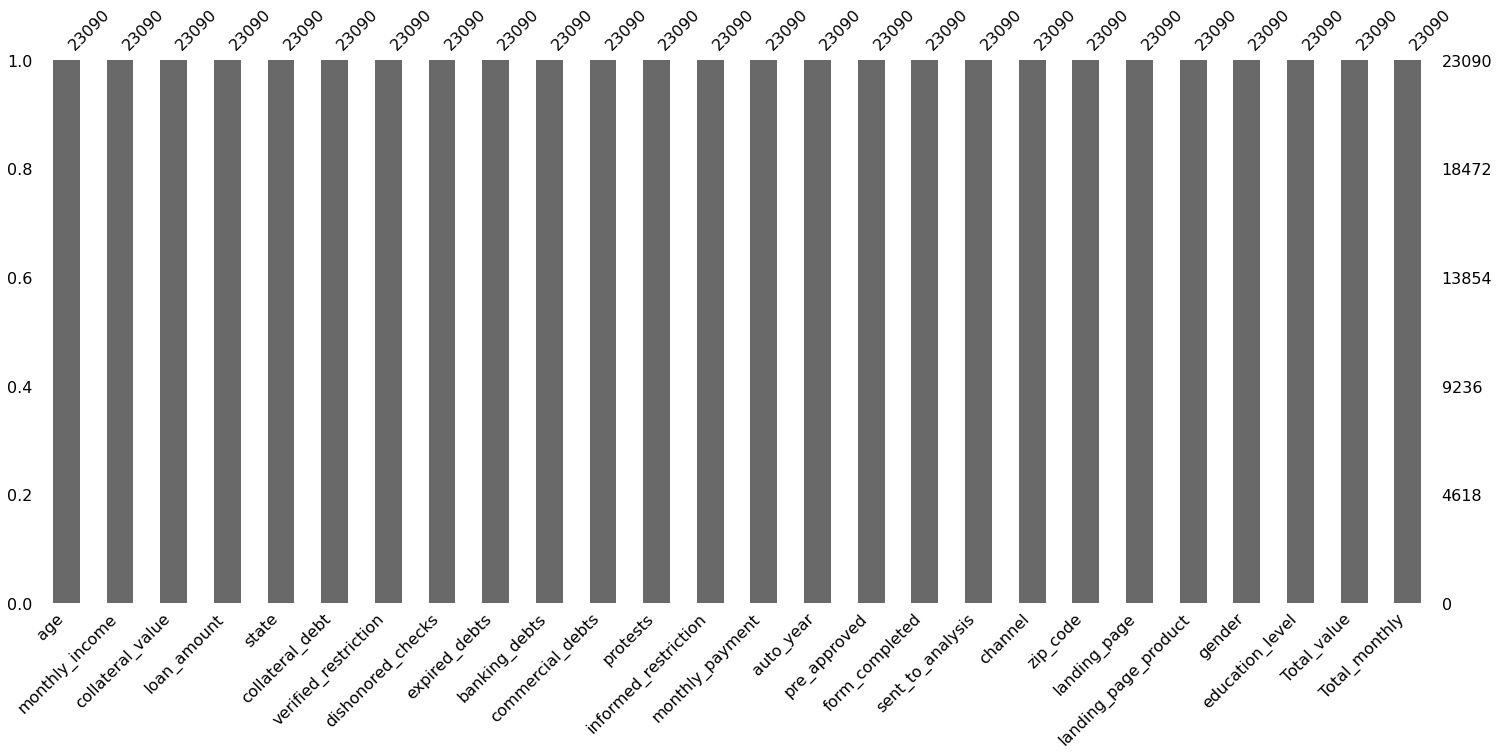

In [16]:
msno.bar(base_pre3)  #sem nan. Base Limpa

### Mapa de correlação entre variáveis  <a id="1.6"></a>

O mapa abaixo indica a correlação entre as variáveis da base. Há forte correlação nas cores mais claras (correlação positiva) e escuras (correlação negativa). A variável pre_aproved está fortemente correlacionada com as variáveis auto_year (ano do carro), verified_restriction (restrições), banking_debts, education_level e sent_to_analysis. A variável sent_to_analysis possui boa correlação com as variáveis verified_restriction, loan_amount e education_level. 

<AxesSubplot:>

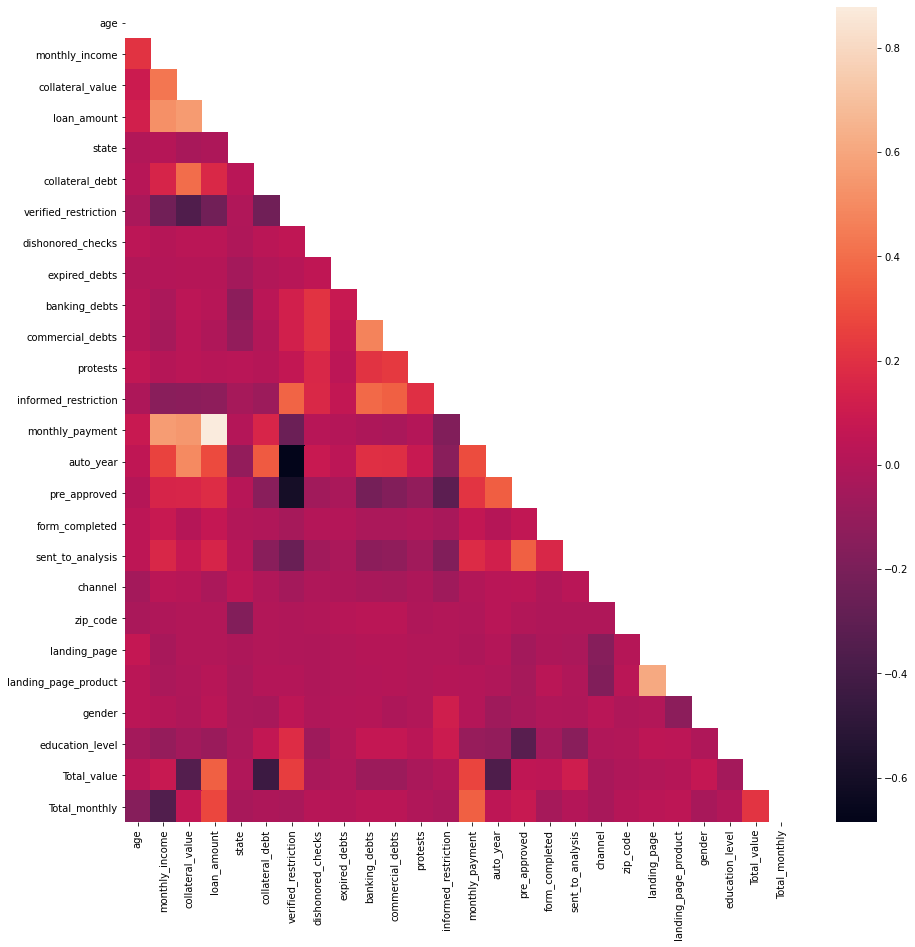

In [17]:
matrix = np.triu(base_pre3.corr())
plt.figure(figsize=(15,15))
sns.heatmap(base_pre3.corr(), mask=matrix)

### Visualização da base final  <a id="1.7"></a>

In [18]:
preditores = ['age', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'monthly_payment', 
              'auto_year', 'Total_value', 'Total_monthly', 'pre_approved', 'form_completed', 'education_level', 
              'verified_restriction', 'zip_code', 'gender', 'expired_debts', 
              'dishonored_checks', 'protests']
base_final = base_pre3[preditores]
base_final.head(10)

,age,monthly_income,collateral_value,loan_amount,collateral_debt,monthly_payment,auto_year,Total_value,Total_monthly,pre_approved,form_completed,education_level,verified_restriction,zip_code,gender,expired_debts,dishonored_checks,protests
id,,,,,,,,,,,,,,,,,,
173465,-0.3750,-0.133333,-0.117647,-0.400,1.427286,-0.551554,-0.125,0.178571,0.080127,0,1,9,0,3,1,0,0,0
173464,0.8750,0.200000,0.058824,0.100,1.141571,-0.251375,0.375,0.344828,0.089869,0,0,9,1,1,1,0,0,1
173463,0.8750,-0.500000,-0.588235,-0.100,-0.001286,-0.225838,-1.625,0.800000,0.222220,0,0,9,2,9,1,0,0,0
173462,-0.7500,0.333333,1.117647,0.100,4.713000,1.445840,0.250,0.138889,0.243718,0,0,9,0,2,1,0,0,0
173461,1.6250,0.700000,-0.558824,0.045,-0.001286,-0.297730,-1.250,0.900000,0.059949,0,0,9,2,5,1,0,0,0
173460,0.9375,0.889333,0.235294,-0.400,0.127286,-0.672877,0.250,0.200803,0.028541,1,0,7,0,4,0,0,0,0
173458,1.0625,0.266667,-0.705882,-0.400,-0.001286,-0.551554,-2.625,0.625000,0.054824,0,0,9,2,2,1,0,0,0
173457,-0.7500,-0.600000,-0.588235,-0.100,0.284429,-0.008677,-2.875,0.666667,0.347225,0,0,9,2,8,0,0,0,0
173455,-1.0625,0.666667,-0.341176,-0.400,0.213000,-0.365948,-0.625,0.318471,0.055912,1,0,7,0,7,1,0,0,0


In [23]:
path = r'C:\Users\bruno\Documents\Testes - Data Science\desafio-ds-creditas'
base_final.to_csv(path+'\\base_final.csv')

In [20]:
base_final

,age,monthly_income,collateral_value,loan_amount,collateral_debt,monthly_payment,auto_year,Total_value,Total_monthly,pre_approved,form_completed,education_level,verified_restriction,zip_code,gender,expired_debts,dishonored_checks,protests
id,,,,,,,,,,,,,,,,,,
173465,-0.3750,-0.133333,-0.117647,-0.400000,1.427286,-0.551554,-0.125,0.178571,0.080127,0,1,9,0,3,1,0,0,0
173464,0.8750,0.200000,0.058824,0.100000,1.141571,-0.251375,0.375,0.344828,0.089869,0,0,9,1,1,1,0,0,1
173463,0.8750,-0.500000,-0.588235,-0.100000,-0.001286,-0.225838,-1.625,0.800000,0.222220,0,0,9,2,9,1,0,0,0
173462,-0.7500,0.333333,1.117647,0.100000,4.713000,1.445840,0.250,0.138889,0.243718,0,0,9,0,2,1,0,0,0
173461,1.6250,0.700000,-0.558824,0.045000,-0.001286,-0.297730,-1.250,0.900000,0.059949,0,0,9,2,5,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98337,0.8125,0.500000,0.000000,-0.400000,0.570143,-0.651510,0.250,0.208333,0.037771,1,0,7,1,1,0,0,0,1
98336,0.6875,-0.433333,-0.705882,-0.400000,-0.001286,-0.378117,-1.500,0.625000,0.161700,0,0,0,2,1,1,0,0,0
98335,-0.1875,-0.716667,-0.352941,-0.400000,0.141571,-0.522891,0.125,0.333333,0.258035,1,0,3,0,5,1,0,0,0


# Modelagem - Etapa 1  <a id="2"></a>

Feito o pré-processamento da base, o próximo passo é a aplicação do modelo de machine learning que deverá prever a classe da variável independente. A modelagem se dará em duas etapas:

1) Prever a probabilidade de ser pré-aprovado;
2) Utilzando a base somente com clientes pré-aprovados, mais o resultado da primeira etapa como uma variáveis dependentes, calcular a probabilidade do cliente ser enviado para análise. Neste caso, a variável independente será a coluna sent_to_analysis.

Na primeira etapa a variável independente será a coluna pre_approved. Transformar essa variável em probabilidades é útil por várias razões: 
<ul>
  <li>Primeiro, parece lógico que pré-aprovados com maiores probabilidades devem ter prioridade no atendimento para análise; </li>
  <li>Segundo, tal variável se tornará útil para a segunda etapa da modelagem, onde a variável pre_approved será filtrada selecionando apenas os pré-aprovados (caso contrário tal variável teria apenas a classe 1, o que não seria útil).</li>
</ul>

### Verificar se a base está balanceada  <a id="2.1"></a>
Com relação à variável pre_approved, podemos verificar que a base  está razoavelmente balanceada, o que não  deve prejudicar o desempenho dos algoritmos de machine learning utilizados.

Não pré-aprovado: 61.59 % of the dataset
Pré-aprovado: 38.41 % of the dataset


<AxesSubplot:xlabel='pre_approved', ylabel='count'>

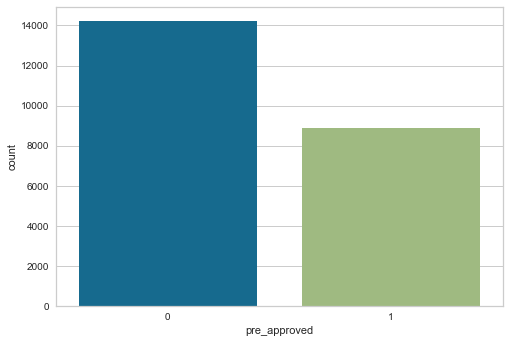

In [25]:
print('Não pré-aprovado:', round(
        base_final['pre_approved'].value_counts()[0]/len(base_final)*100, 2), '% of the dataset')
print('Pré-aprovado:', round(
        base_final['pre_approved'].value_counts()[1]/len(base_final)*100, 2), '% of the dataset')
sns.countplot("pre_approved",data=base_final)

### Aplicando o modelo de machine learning - XGBoost  <a id="2.2"></a>

Primeiros, faremos a separação da base entre treino e teste. A base de treino deve ser selecionada de forma estratificada (mantendo a mesma proporção de classes da variável independente na base de treino com a base original). Com relação à base de teste, devemos prever todas as instâncias, já que devemos concatenar esta coluna na base de treino para a segunda etapa da modelagem.

In [26]:
#A proporção de classes da variável pre_approved na base de treino e de teste deve ser a mesma da base original
X = base_final.drop(['pre_approved'], axis=1).values
y = base_final.pre_approved.values
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=1234)
sss.get_n_splits(X, y)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X
    y_train, y_test = y[train_index], y

O algoritmo XGBoost é um modelo baseado em árvores de decisão que utiliza gradient boosting para aprendizagem. Boosting é uma técnica de conjunto em que novos modelos (no caso, árvores de decisão) são adicionados para corrigir os erros cometidos pelos modelos existentes. Os modelos são adicionados sequencialmente até que não sejam feitas mais melhorias. Gradient Boosting é uma abordagem na qual novos modelos que prevêem os resíduos ou erros de modelos anteriores são criados e depois são adicionados juntos para fazer a previsão final. É chamado de Gradient Boosting porque usa um algoritmo de descida de gradiente para minimizar a perda ao adicionar novos modelos.

Esse algoritmo foi escolhido por diversas razões: É rápido, possui excelente perfomance e tem suporte ao método predict_proba, que permite prever uma variável independente categórica de maneira probabilística. O XGBoost possui muitos hiperparâmetros, e fez-se necessário o uso de Random Search para encontrar os melhores valores de hipeparâmetros.

In [27]:
xgboost = xgb.XGBClassifier(scale_pos_weight=61.59/38.41)

### Calibração de probabilidades  <a id="2.3"></a>

Alguns modelos podem prever as probabilidades com valores muito próximos aos extremos 0 e 1 do intervalo. Por exemplo, os valores 0,0,1,1 podem ser transformado nas probabilidades 0.01, 0.05, 0.99, 0.98. A calibração de probabilidades tem como objetivo amenizar esse efeito, reescalonando a proporção para que a probabilidade se distribua melhor entre o intervalo 0 e 1.


In [28]:
xgb_calibrated = CalibratedClassifierCV(xgboost, cv=3, method='sigmoid')

In [29]:
xgb_calibrated.fit(X_train, y_train)
y_hat = xgb_calibrated.predict_proba(X_test)


### Métrica de avaliação - Área sob a curva ROC  <a id="2.4"></a>

A Curva ROC é uma alternativa de avaliação de um algoritmo classificador, que consiste na utilização de um gráfico bi-dimensional, onde o eixo vertical representa a taxa de verdadeiros positivos e o eixo horizontal representa a taxa de falsos positivos obtida pelo classificador. Quanto mais próximo do ponto $(0, 1)$ (superior à esquerda) melhor é o modelo. Modelos no ponto (0, 0) não classificam nenhuma observação como positivo, e modelos próximos do ponto $(1,1)$ classificam tudo como positivo.

A avaliação da curva ROC pode ser feita analisando a área sob esta curva e quanto maior a área, mais próximo a curva se aproxima do lado superior esquerdo, e melhor é a perfomance do modelo. A curva AUC ROC foi utilizada aqui porque permite a avaliação entre uma variável categórica e uma variável com valores probabilísticos, diferente da acurpacia, que compara apenas valores categóricos.

O modelo conseguiu um desempenho muito satisfatório para prever quem seria pré-aprovado, obtendo uma área muito próxima de 1 (0.98). A curva ROC é mostrada abaixo.



In [30]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_hat[:,1])
roc_auc = metrics.auc(fpr, tpr)
print('A Área sob a curva ROC é %0.3f:' %roc_auc)

A Área sob a curva ROC é 0.988:


In [31]:
len(y_test)

23090

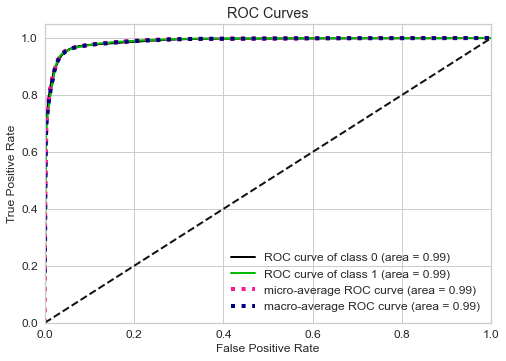

In [32]:
skplt.metrics.plot_roc(y_test, y_hat);

### Outras métricas importantes  <a id="2.5"></a>
 Além da área sob a curva ROC, a avaliação de outras variáveis torna-se importante:
<ul>
  <li><b>Precisão:</b> Mede a porcentagem de acertos entre as observações classificadas como positivas (ou negativa);</li>
  <li><b>Recall ou sensibilidade: </b>Também chamada de taxa de verdadeiro positivo, mede a porcentagem das observações positivas que foram corretamente classificadas;</li>
  <li><b>F1:</b>Essa medida busca um equilíbrio entre a sensibilidade e a precisão, utilizando a média harmônica dessas métricas:
 $$F1=\frac{2\times precisão\times recall}{precisão+recall}$$</li>
  <li><b>Acurácia:</b>Também chamada de taxa de verdadeiro positivo, mede a porcentagem das observações positivas que foram corretamente classificadas;</li>
</ul>
  
Para avaliar o modelo com essas métricas, é necessário transformar a variável com valores probabilísticos em variável categórica. Geralmente, usa-se o limiar 0.5 para transformação. Por exemplo, se as probabilidades medidas foram 0.3,0.1,0.6 0.8, com limiar classificaríamos tais probabilidades como 0,0,1 e 1, respectivamente. Nem sempre 0.5 é o melhor limiar. Aqui, usaremos uma função que encontra o limiar ótimo, que maximiza o valor da acurácia. Encontramos como melhor limiar o valor 0.45, e como resultado temos uma acurácia de 95.3%, um valor muito bom, pois está bem acima da linha base de classificação, de 61.59% (em bases desbalanceadasm, usa-se como linha base a proporção da classe majoritária na variável que, no caso da coluna pre_approved, é de 61.59%). As outras métricas também tiveram ótimos resultados, comprovando a capacidade do modelo para predição de pré-aprovados.

In [33]:
scores_rfc=[] 
tresholds = np.linspace(0 , 1 , 200)
for treshold in tresholds:
    y_hat_rfc = (y_hat[:,1] > treshold).astype(int)
    scores_rfc.append([metrics.recall_score(y_pred=y_hat_rfc, y_true=y_test),
                 metrics.precision_score(y_pred=y_hat_rfc, y_true=y_test),
                 metrics.fbeta_score(y_pred=y_hat_rfc, y_true=y_test, beta=1),
                 metrics.accuracy_score(y_pred=y_hat_rfc, y_true=y_test)])
scores_rfc = np.array(scores_rfc)
final_tresh = tresholds[scores_rfc[:, 3].argmax()]
y_hat_rfc = (y_hat > final_tresh).astype(int)
best_score = scores_rfc[scores_rfc[:, 3].argmax(),:]
recall_score = best_score[0]
precision_score = best_score[1]
fbeta_score = best_score[2]
acurácia = best_score[3]

print('The recall score is: %.3f' % recall_score)
print('The precision score is: %.3f' % precision_score)
print('The f1 score is: %.3f' % fbeta_score)
print('The accuracy score is: %.3f' % acurácia)


The recall score is: 0.945
The precision score is: 0.938
The f1 score is: 0.942
The accuracy score is: 0.955


Por último, podemos avaliar o número de instâncias classificadas corretamente utilizando uma matriz de confusão. A grande parte das intâncias foram classificadas corretamente (quadrante superior esquerdo e inferior direito).

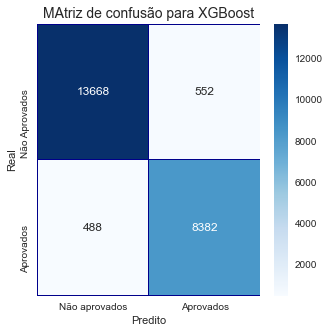

In [34]:
cm = pd.crosstab(y_test, y_hat_rfc[:,1], rownames=['Real'], colnames=['Predito'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Não aprovados', 'Aprovados'],
            yticklabels=['Não Aprovados', 'Aprovados'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt="d")
plt.title('MAtriz de confusão para XGBoost', fontsize=14)
plt.show()

### Importância via permutação das variáeis  <a id="2.6"></a>

O algoritmo Permutation Importance mede a importância de uma variável calculando o aumento no erro de previsão do modelo depois de permutá-lo. Um recurso é "importante" se o embaralhamento de seus valores aumenta o erro do modelo, pois nesse caso o modelo contava com o recurso para a previsão. Um recurso é "sem importância" se o embaralhamento de seus valores deixa o erro do modelo inalterado, pois nesse caso o modelo ignorou o recurso para a previsão.

De acordo com o método de permutação, as variáveis mais importantes são verified_restriction (se o cliente possui restrição), auto_year (ano do corra) e collateral_debt, que aumentaram a acurácia do modelo em 53% somadas.

In [35]:
perm = PermutationImportance(xgb_calibrated).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = base_final.drop(['pre_approved'], axis=1).columns.tolist())

Weight,Feature
0.1935 ± 0.0022,auto_year
0.1900 ± 0.0051,verified_restriction
0.1251 ± 0.0030,collateral_debt
0.0626 ± 0.0025,education_level
0.0292 ± 0.0012,monthly_payment
0.0247 ± 0.0011,Total_monthly
0.0228 ± 0.0006,collateral_value
0.0216 ± 0.0021,age
0.0195 ± 0.0010,Total_value
0.0156 ± 0.0018,monthly_income


# Modelagem - Etapa 2  <a id="3"></a>

Nesta etapa, vamos prever a variável sent_to_analysis (cientes enviados para análise). Para isso, vamos adicionar como variável dependente a probabilidade de ser pré-aprovado que previmos na etapa anterior. Também vamos remover todas os clientes que não foram pré-aprovados.

In [36]:
#concatena a variável prevista na etapa anterior e remove todas as instâncias que não foram pré-aprovadas
X1 = np.concatenate((X, y_hat[:,1].reshape(-1,1)), axis=1)[y==1,:]
y1 = base_pre3.sent_to_analysis.values
y1 = y1[y==1,]
pd.DataFrame(X1).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.9375,0.889333,0.235294,-0.400,0.127286,-0.672877,0.250,0.200803,0.028541,0.0,7.0,0.0,4.0,0.0,0.0,0.0,0.0,0.927541
1,-1.0625,0.666667,-0.341176,-0.400,0.213000,-0.365948,-0.625,0.318471,0.055912,0.0,7.0,0.0,7.0,1.0,0.0,0.0,0.0,0.901437
2,0.6875,0.000000,-0.176471,-0.100,0.150143,0.071136,0.125,0.442968,0.149100,0.0,4.0,0.0,6.0,1.0,0.0,0.0,0.0,0.929460
3,1.1875,1.500000,0.058824,0.300,-0.001286,0.653907,0.375,0.571429,0.089460,0.0,9.0,1.0,4.0,1.0,0.0,0.0,0.0,0.069689
4,-0.1250,0.126333,-0.205882,-0.400,-0.001286,-0.225838,-0.125,0.303030,0.098648,0.0,7.0,0.0,8.0,1.0,0.0,0.0,0.0,0.928879
5,-0.8750,-0.433333,-0.794118,-0.315,-0.001286,-0.289887,-0.250,0.900000,0.181618,0.0,7.0,0.0,6.0,1.0,0.0,0.0,0.0,0.928075
6,0.6875,0.500000,1.176471,1.600,0.331571,2.343695,0.250,0.590598,0.293209,0.0,6.0,0.0,3.0,1.0,0.0,0.0,0.0,0.925301
7,0.1250,2.800000,-0.276471,0.477,-0.001286,0.799307,-0.625,0.900000,0.063750,0.0,4.0,0.0,8.0,1.0,0.0,0.0,0.0,0.890292
8,1.0000,0.166667,-0.357529,0.200,-0.001286,1.000808,-0.625,0.790116,0.229737,0.0,7.0,0.0,1.0,2.0,0.0,0.0,0.0,0.874490
9,0.1250,0.943333,0.882353,-0.400,0.570143,0.175730,0.500,0.128205,0.083609,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.916696


Aqui notamos que uma base bem mais desbalanceada que a anterior, com uma proporção 80.9/19.1 (aproximadamente 4:1). A linha base de classificação deverá ser de 80.9% (valor da acurácia caso classificássemos todas as intâncias pertencentes à classe majoritária).

Não enviados para análise 80.9 % of the dataset
Enviados para análise 19.1 % of the dataset


<AxesSubplot:xlabel='sent_to_analysis', ylabel='count'>

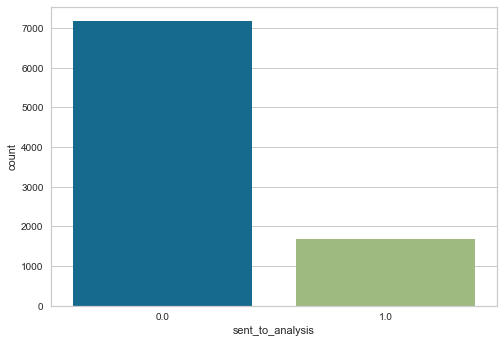

In [37]:
print('Não enviados para análise', round(
        base_pre3.sent_to_analysis[base_pre3['pre_approved']==1].value_counts()[0]/len(X1)*100, 2), '% of the dataset')
print('Enviados para análise', round(
        base_pre3.sent_to_analysis[base_pre3['pre_approved']==1].value_counts()[1]/len(X1)*100, 2), '% of the dataset')
sns.countplot("sent_to_analysis",data=base_pre3[base_pre3['pre_approved']==1])

A separação entre treino e teste aqui também deve ser estratificada para manter a mesma proporção de clientes enviados para análise da base original. A base de teste será composta por 20% da base original, enquanto as outra parte será a base para treinar o algoritmo de machine learning.

In [38]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
sss.get_n_splits(X1, y1)
for train_index, test_index in sss.split(X1, y1):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]

### Aplicando o modelo de machine learning - Random Forest <a id="3.1"></a>

De uma maneira simplificada, o algoritmo random forest cria várias árvores de decisão e as combina para obter uma previsão mais precisa e mais estável (um processo conhecido como bagging). O algoritmo Random Forest possui vários hiperparâmetros que precisam ser configurados para otimizar o desempenho. Usaremos o método RandomizedSearchCV para encontrar os melhores hiperparâmetros no modelo. O algoritmo random forest obteve obteve melhor desempenho que outros algoritmos para esta base, como XGBoost, motivo deste algoritmo ter sido selecionado para previsão. Nesse etapa, vamos aplicar a técnica de oversampling SMOTE na base de treino e prever em um base de treino desbalanceada.

<a href="https://medium.com/@ar.ingenious/applying-random-forest-classification-machine-learning-algorithm-from-scratch-with-real-24ff198a1c57">
         <img alt="Qries" src='https://miro.medium.com/max/1170/1*58f1CZ8M4il0OZYg2oRN4w.png'
         width=500" height="300">


In [41]:
def otimizador_xgboost(model, X, y, metrica='roc_auc', n_chamadas=50):
    space  = [Integer(200, 2000, name='n_estimators'),
              Categorical([True, False], name='bootstrap'),
              Integer(10, 110, name='max_depth'),
              Integer(2, 100, name='min_samples_split'),
              Integer(1, 100, name='min_samples_leaf')]
    # definindo a função para ser otimizada
    @use_named_args(space)
    def evaluate_model(**params):
        model.set_params(**params)
        # calculando o cross-validation com 5 folds
        return 1-np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                        scoring="roc_auc"))
    # aplicando a otimização via processo gaussiano

    # this decorator allows your objective function to receive a the parameters as
    # keyword arguments. This is particularly convenient when you want to set scikit-learn
    # estimator para meters
    @use_named_args(space)
    def objective(**params):
        reg.set_params(**params)

        return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                        scoring="neg_mean_absolute_error"))
    result = gp_minimize(evaluate_model, space, verbose=True, n_calls= 50)
    # resumindo os resultados:
    print('Best AUC_ROC: %.5f' % (1.0 - result.fun))
    best_params = {'max_depth': result.x[0], 'learning_rate': result.x[1], 'max_features': result.x[2], 'min_samples_split':result.x[3], 
           'min_samples_leaf': result.x[4]}
    print(best_params)
    return best_params

In [45]:
from skopt import gp_minimize
from skopt.space import Categorical, Integer, Real
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score

best_params = otimizador_xgboost(rfc, X_train, y_train, metrica='roc_auc', n_chamadas=50)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.3842
Function value obtained: 0.1018
Current minimum: 0.1018
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 15.4314
Function value obtained: 0.1161
Current minimum: 0.1018
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 9.5617
Function value obtained: 0.1127
Current minimum: 0.1018
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 24.3730
Function value obtained: 0.1059
Current minimum: 0.1018
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 20.6082
Function value obtained: 0.0884
Current minimum: 0.0884
Iteration No: 6 started. Evaluat

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 59.7583
Function value obtained: 0.0390
Current minimum: 0.0389
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 60.0066
Function value obtained: 0.0389
Current minimum: 0.0389
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 64.5184
Function value obtained: 0.0391
Current minimum: 0.0389
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 62.4319
Function value obtained: 0.0390
Current minimum: 0.0389
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 6.7820
Function value obtained: 0.1080
Current minimum: 0.0389
Iteration No: 46 started.

In [50]:
best_params = {'n_estimators': 2000,
 'bootstrap': False,
 'max_depth': 106,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'class_weight': 'balanced'}

In [51]:
#aplica os hiperparâmetros encontrados pelo tuning de parâmetros
rfc = RandomForestClassifier(**best_params)
rfc_calibrated = CalibratedClassifierCV(rfc, cv=3, method='isotonic')

rfc_calibrated.fit(X_train, y_train)
X_test = pd.DataFrame(X_test, columns=preditores)
y_hat = rfc_calibrated.predict_proba(X_test)

### Avaliação do modelo <a id="3.2"></a>

Devido ao fato da base ser desbalanceada, devemos tomar cuidado em como iremos avaliar a perfomance do modelo. Nos basearemos na curva ROC e no lift do modelo.

In [52]:
# calculate the fpr and tpr for all thresholds of the classification
roc_auc = metrics.roc_auc_score(y_test, y_hat[:,1], average= 'weighted')
print('A Área sob a curva ROC é %0.3f:' %roc_auc)

A Área sob a curva ROC é 0.782:


<b>Área sobre a cuva ROC </b>
A curva ROC avalia como a taxa de verdadeiros positivo vs falsos positivos para diferentes limiares. Essa métrica permite verificar o quanto o modelo consegue ser melhor que a baseline (linha tracejada) a partir da área sob as curvas ROCS para a classe 0 e 1. O resultado obtido é satisfatório.

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

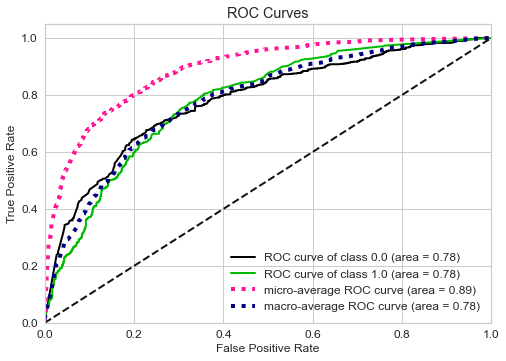

In [53]:
skplt.metrics.plot_roc(y_test, y_hat)

<b>Teste KS </b>

O teste não-paramétrico de Kolmogorov-Smornov avalia distancia entre diferentes distribuições. Nesse caso, usamos o teste KS para identifica o limiar que melhor separa as classes 0 e 1 do modelo (0.189)

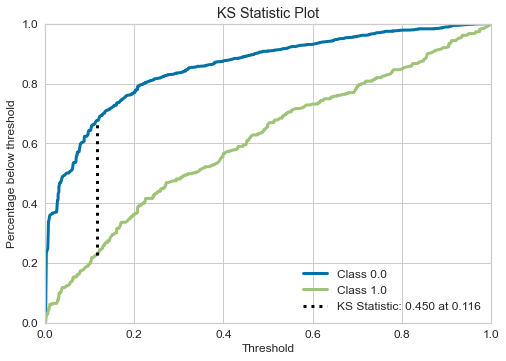

In [54]:
skplt.metrics.plot_ks_statistic(y_test, y_hat);

<b> Teste de calibração </b>
Uma score calibrado permite avaliar se ele represente a verdadeira probabilidade da predição, avaliando o valor médio predito de uma fração cumulativa dos valores de classe positiva da amostra da base de dados. 

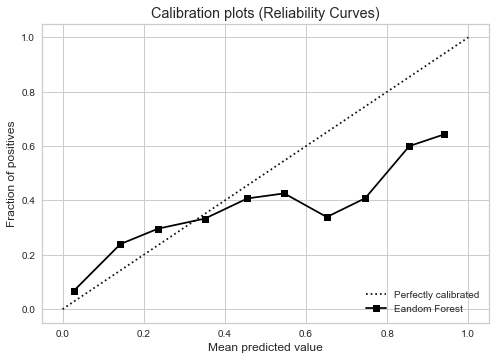

In [58]:
skplt.metrics.plot_calibration_curve(y_test, [y_hat], ['Eandom Forest']);

<b> O lift </b> avalia o quanto o modelo perfome melhor que uma classificação aleatória. No gráfico abaixo, quanto mais a área entre a baseline e a curva de lift, melhor o desempenho. Apesar da curva de lift para a classe 0 não ter tido um bom resultado (a razão é justamente o fato da base ser desbalanceada, o que leva a maior taxa de falsos positivos para essa classe), o modelo cumpre seu objetivo ao ter uma boa perfomance em avaliar as instâncias da classe positiva.

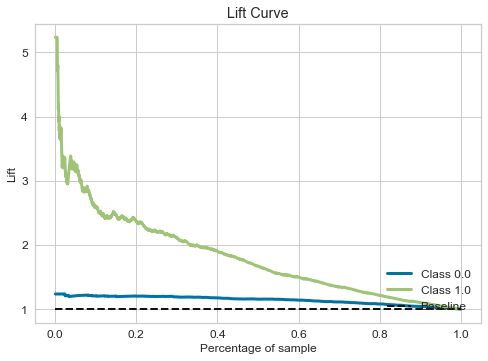

In [59]:
skplt.metrics.plot_lift_curve(y_test, y_hat);

In [57]:
scores_rfc=[] 
tresholds = np.linspace(0 , 1 , 200)
for treshold in tresholds:
    y_hat_rfc = (y_hat[:,1] > treshold).astype(int)
    scores_rfc.append([metrics.recall_score(y_pred=y_hat_rfc, y_true=y_test),
                 metrics.precision_score(y_pred=y_hat_rfc, y_true=y_test),
                 metrics.fbeta_score(y_pred=y_hat_rfc, y_true=y_test, beta=1),
                 metrics.accuracy_score(y_pred=y_hat_rfc, y_true=y_test)])
scores_rfc = np.array(scores_rfc)
final_tresh = tresholds[scores_rfc[:,3].argmax()]
y_hat_rfc = (y_hat > final_tresh).astype(int)
best_score = scores_rfc[scores_rfc[:, 3].argmax(),:]
recall_score = best_score[0]
precision_score = best_score[1]
fbeta_score = best_score[2]
acurácia = best_score[3]

print('The recall score is: %.3f' % recall_score)
print('The precision score is: %.3f' % precision_score)
print('The f1 score is: %.3f' % fbeta_score)
print('The accuracy score is: %.3f' % acurácia)

The recall score is: 0.174
The precision score is: 0.621
The f1 score is: 0.272
The accuracy score is: 0.822


<h3> Seleção de Modelos </h3>

A biblioteca pycaret está se mostrando extramamente valiosa, podendo aceler o trabalho do cientista de dados com diversas funções eautomação no preprocessamente e melhoria dos modelos de machine learning. Abaixo podemos identificar que o melhor modelo é o Gradiente Boosting, com uma curva ROC de 0.82.

In [101]:
from pycaret.classification import setup, compare_models

In [109]:
X1 = pd.DataFrame(X1)

In [112]:
X1['sent_to_analysis'] = X1.sent_to_analysis.astype('O')

In [113]:
exp_clf101 = setup(data = X1, target = 'sent_to_analysis', session_id=123)

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,"0.0: 0, 1.0: 1"
3,Original Data,"(8870, 19)"
4,Missing Values,False
5,Numeric Features,14
6,Categorical Features,4
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [114]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.8270,0.8285,0.2994,0.5971,0.3972,0.3092,0.3351,1.1058
1,Logistic Regression,0.8260,0.8100,0.2277,0.6241,0.3329,0.2571,0.3009,0.1616
2,Ada Boost Classifier,0.8244,0.8208,0.3136,0.5756,0.4051,0.3126,0.3329,0.3679
3,Linear Discriminant Analysis,0.8231,0.7852,0.2116,0.6128,0.3136,0.2385,0.2839,0.0263
4,Extra Trees Classifier,0.8225,0.8040,0.2622,0.5783,0.3602,0.2739,0.3031,0.3750
5,CatBoost Classifier,0.8222,0.8225,0.2925,0.5689,0.3858,0.2941,0.3167,6.6868
6,Light Gradient Boosting Machine,0.8175,0.8154,0.3044,0.5402,0.3880,0.2909,0.3080,0.1932
7,Ridge Classifier,0.8149,0.0000,0.0717,0.6664,0.1285,0.0939,0.1719,0.0116
8,Extreme Gradient Boosting,0.8123,0.7996,0.3230,0.5178,0.3967,0.2926,0.3047,0.3890
9,Random Forest Classifier,0.8104,0.7570,0.2395,0.5107,0.3244,0.2310,0.2540,0.1231


### Feature Importance <a id="3.3"></a>

O algoritmo random forest possui um método que avalia a importância das variáveis para a previsão. De acordo com o gráfico abaixo, as variáveis pre_approved (13%), collateral_debt (10%) e monthly_payment (9%) foram as mais importantes para aumento da perfomance do modelo.

In [ ]:
predictors = ['age', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'monthly_payment', 
              'auto_year', 'Total_value', 'Total_monthly', 'form_completed', 'education_level', 
              'verified_restriction', 'zip_code', 'gender', 'expired_debts', 
              'dishonored_checks', 'protests', 'pre_approved']
rfc.fit(X_train, y_train)
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': rfc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance - Random Forest',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

### Importância via permutação das variáveis <a id="3.4"></a>

De acordo com o método de permutação, a variável pre-approved aumentou a acurácia em 2.89%. Nenhuma outra variável influenciou significativamente para a previsão. 

In [ ]:
perm = PermutationImportance(rfc_calibrated).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

# Conclusão <a id="4"></a>

este trabalho, foi desenvolvido um modelo para calcular a probabilidade de uma cliente ser enviado para análise de crédito. Como resultado, obtivemos uma acurácia de de 95% e área sob a curva ROC de 0.98, o que demonstra a eficácia do modelo para previsão de pré-aprovados para análise de crédito. Na avaliação do atual método de decisão para análise de clientes que devem ser enviados para análise, os melhores modelos de machine learning demonstrou-se satisfatório para predição, com área sob a curva ROC de 0.79. Podemos então enviar para análise os N top clientes com maiores probabilidade. 